# Multi-Client Side

## Imports

In [1]:
import os
import time

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Subset
from torchvision.datasets import MNIST, SVHN, USPS
import matplotlib.pyplot as plt

### User imports

In [2]:
from src.lib import *

## SET CUDA(client use CPUs)

In [3]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
torch.manual_seed(777)
if device =="cuda:0":
    torch.cuda.manual_seed_all(777)

## set main variables

In [4]:
data_path = './models/'
nuser = 4
datasize_total = 32000
datasize_per_client = datasize_total // nuser

In [5]:
host = "localhost"
port = 10085

## Data load

In [6]:
# resize every image into 32x32
# Order: MNIST, USPS, SVHN, MNIST-M, SYNTH
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                transforms.Resize((32, 32))
                               ])
transform_to_rgb = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                       transforms.Resize((32, 32))
                                      ])

### Load every dataset `train_datasets: list`

In [7]:
train_mnist = MNIST(root=data_path + 'mnist_data', train=True, download=True, transform=transform_to_rgb)
train_svhn = SVHN(root=data_path + 'svhn_data', split="train", download=True, transform=transform)
train_mnistm = MNISTM(root=data_path + 'mnist-m_data', train=True, download=True, transform=transform)
train_synth = SyntheticDigits(root=data_path + 'synthdigit_data', train=True, download=True, transform=transform)
train_usps = USPS(root=data_path + 'usps_data', train=True, download=True, transform=transform_to_rgb)
train_datasets = [train_mnist, train_svhn, train_mnistm, train_synth, train_usps] # usps at the end

Using downloaded and verified file: ./models/svhn_data/train_32x32.mat
./models/mnist-m_data/MNISTM/processed/mnist_m_train.pt
./models/synthdigit_data/SyntheticDigits/processed/synth_train.pt


### dataset into DataLoader `train_loaders: list`

In [8]:
# train 6400: test 1000
indices = list(range(datasize_per_client))
train_loaders = []
for i, data_set in enumerate(train_datasets):
    loader = torch.utils.data.DataLoader(Subset(data_set, indices), batch_size=16, shuffle=True, num_workers=2)
    train_loaders.append(loader)

### Size batch check

In [9]:
x_train, y_train = next(iter(train_loaders[0]))
print(x_train.size())
print(y_train.size())
batchsize_per_loader = len(train_loaders[0])
print(batchsize_per_loader)

torch.Size([16, 3, 32, 32])
torch.Size([16])
500


[60000, 73257, 60000, 479400, 7291]
[500, 500, 500, 500, 500]


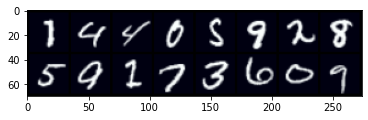

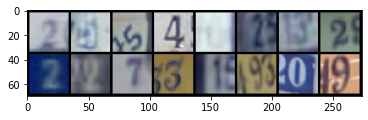

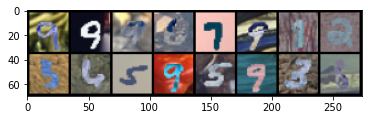

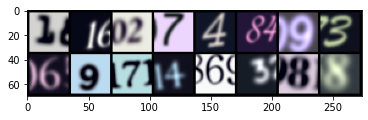

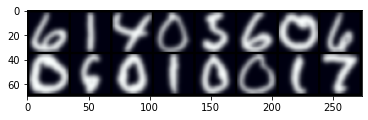

In [10]:
print([len(x) for x in train_datasets])
print([len(x) for x in train_loaders])
for train_loader in train_loaders:
    batch_imgs, batch_labels = next(iter(train_loader))
    grid_img = torchvision.utils.make_grid(batch_imgs, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

## Define model

In [11]:
client_models = []
for i in range(nuser):
    client_model = ClientMobileNet()
    client_model = client_model.to(device)
    client_models.append(client_model)

### Set other hyperparameters in the model
Hyperparameters here should be same with the server side.

In [12]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(client_model.parameters(), lr=lr, momentum=0.9)

## Allocate ONE client, connect with server, get ready

In [13]:
client = Client(host, port)
client.connect()
epochs = client.training_prep(batchsize_per_loader) # client's training_prep returns the number of epoch

## SET TIMER

In [14]:
start_time = time.time()    # store start time
print("training start!")

training start!


## Real training process

In [15]:
# receive initial weight from server
client_weights, _ = client.recv()

for client_model in client_models:
    client_model.load_state_dict(client_weights)

for e in range(epochs):
    for cidx, client_model in enumerate(client_models):
        client_model.eval()
        for i, data in enumerate(tqdm(train_loaders[cidx], ncols=100, desc='Epoch {} client {}'.format(e+1, cidx))):
            x, label = data
            x = x.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = client_model(x)
            client_output = output.clone().detach().requires_grad_(True)
            msg = {
                'client_output': client_output,
                'label': label
            }
            client.send(msg)
            client_grad, _ = client.recv()
            output.backward(client_grad)
            optimizer.step()


Epoch 10 client 3: 100%|██████████████████████████████████████████| 500/500 [00:11<00:00, 42.17it/s]


In [16]:
for client_model in client_models:
    client.send(client_model.state_dict())

In [17]:
elapsed_time = time.time() - start_time
print("elapsed time for training using", device ,": {} sec".format(elapsed_time))

elapsed time for training using cpu : 454.1818609237671 sec
